# 1.) Import an asset price from Yahoo Finance

In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("ESLOY", start="1990-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]


[*********************100%***********************]  1 of 1 completed


In [11]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-30,28.850000,28.850000,28.850000,28.850000,23.665510,0
2008-01-31,28.740000,28.900000,28.250000,28.740000,23.575272,37400
2008-02-01,29.350000,29.400000,28.850000,29.350000,24.075653,41600
2008-02-04,28.600000,28.750000,28.600000,28.600000,23.460436,16400
2008-02-05,27.500000,28.500000,27.500000,27.500000,22.558109,19900
...,...,...,...,...,...,...
2022-02-14,92.209999,93.099998,91.639999,92.750000,91.200264,29400
2022-02-15,95.610001,96.720001,95.510002,96.410004,94.799118,41300
2022-02-16,95.720001,96.150002,95.029999,96.029999,94.425461,21600


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [12]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    if train_data[i, 0] > 0:
        y_train.append(1)
    else:
        y_train.append(0)

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1)) 


#Examples
#model.add(LSTM(50, return_sequences=False))
#model.add(Dense(25))



model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
2827/2827 [==============================] - 9s 2ms/step - loss: 8.0699
Epoch 2/3
2827/2827 [==============================] - 6s 2ms/step - loss: 8.0699
Epoch 3/3
2827/2827 [==============================] - 6s 2ms/step - loss: 8.0699


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [16]:
train_data = scaled_data[:training_data_len, :]

x_train = []
y_train = np.array(stock_data[["Close"]].pct_change().dropna())[:training_data_len, :]
for i in range(input_size, len(train_data) - (input_size - 1)):
    x_train.append(train_data[i-input_size:i, 0])

x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

y_train = y_train[input_size-1:len(x_train)+input_size-1]

in_predictions = model.predict(x_train)

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

out_predictions = model.predict(x_test)

#Calculate RMSE
in_sample_rmse = np.sqrt(np.mean((y_train - in_predictions)**2))
in_sample_rw_rmse = np.sqrt(np.mean((y_train[1:] - y_train[:-1])**2))

out_sample_rmse = np.sqrt(np.mean((y_test - out_predictions)**2))
out_sample_rw_rmse = np.sqrt(np.mean((y_test[1:] - y_test[:-1])**2))

23/23 [==============================] - 0s 1ms/step


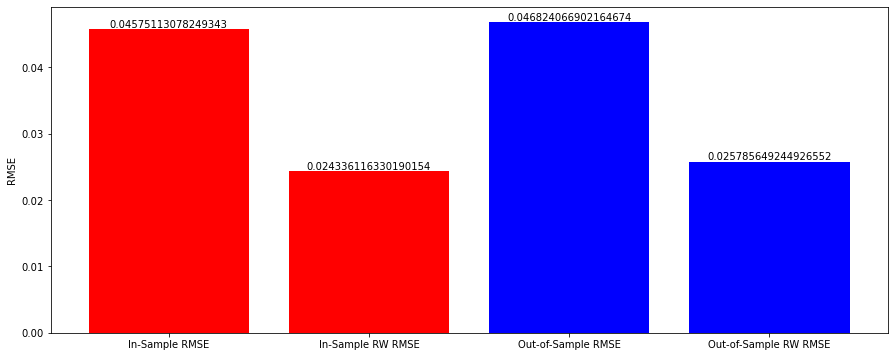

In [18]:
import matplotlib.pyplot as plt

accuracy_scores = [in_sample_rmse, in_sample_rw_rmse, out_sample_rmse, out_sample_rw_rmse]
labels = ['In-Sample RMSE', 'In-Sample RW RMSE', 'Out-of-Sample RMSE', 'Out-of-Sample RW RMSE']
colors = ['r', 'r', 'b', 'b']

fig, ax = plt.subplots(figsize = (15,6))
ax.bar(labels, accuracy_scores, color=colors)
for i, m in enumerate(accuracy_scores):
    ax.text(i, m, str(m), ha='center', va='bottom')
ax.set_ylabel('RMSE')
plt.show()

# 5.) Write an observation/conclusion about the graphs from Q4 and Q3

The model we used to predict the stock price did not perform a random walk.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [19]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

In [20]:
# Define the Keras model
###Edit here to create your optimizer
def create_model(neurons):  #JEN add a parameter
    model = Sequential()
    #model.add(Dense(neurons, input_dim=60, activation='LTSM'))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(neurons,input_dim=60, ))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
param_grid = {#'batch_size': [10, 15, 20],
              #'epochs': [1],
              'neurons':[5,50,100]
            }

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

E:\anaconda_download\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  del sys.path[0]


Best: -0.003756 using {'neurons': 50}
